In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import json

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## allow the import of the MovieData class
import sys
import os
path = os.path.abspath(os.getcwd()) + '/../data_load'
sys.path.insert(0, path)

from movie_data import MovieData

%matplotlib inline

['Action' 'Adventure' 'Comedy' 'Crime' 'Drama' 'Horror' 'Romance'
 'Thriller']


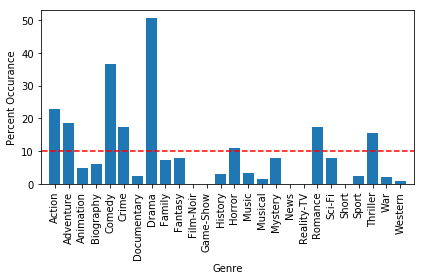

In [2]:
moviedata = MovieData(min_genre_frequency=0.1)
print(moviedata.genres_unique)
moviedata.plot_genres()

In [3]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [14]:
n_features = 5000
n_top_words = 20

count_vectorizor = CountVectorizer(
        max_df=0.95, 
        min_df=2,
        max_features=n_features,
        stop_words='english'
)
count = count_vectorizor.fit_transform(moviedata.plots)
count_feature_names = count_vectorizor.get_feature_names()

lda = LatentDirichletAllocation(
        n_topics=8, max_iter=15,
        learning_method='online',
        learning_offset=50.,
        random_state=0
)
Z = lda.fit_transform(count)

In [15]:
print_top_words(lda, count_feature_names, n_top_words)

Topic #0:
professor king prince princess invention ma queen oil england throne bennett land lord east coast tournament royal chinese lily pakistan
Topic #1:
new york city family world life story school money young film lives harry team american students ray real follows mind
Topic #2:
earth group evil years human world alien crew planet save ship team son race los angeles help time michael new
Topic #3:
life man young family father old love mother woman story town year years time finds help son daughter home lives
Topic #4:
war police world agent murder group killer drug team american secret mission bond case man fbi detective forces government president
Topic #5:
alex lee danny hannah winter wilderness julie bent guide lion scam pat pearl lizzie rush hughes black hole various irving
Topic #6:
school friends life high friend best love new night day college big movie just sex star gets girl time party
Topic #7:
charlie victor darkness experiments bridge madness wallace matrix exorcism t

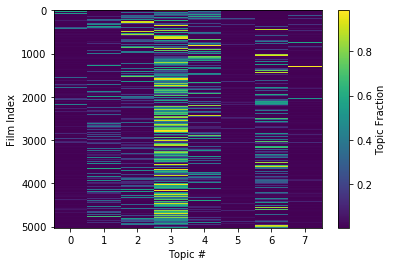

In [34]:
fig = plt.figure('lda_features')
ax = fig.add_subplot(111)
im = ax.imshow(Z, aspect='auto')
ax.set_xlabel('Topic #')
ax.set_ylabel('Film Index')
cbar = plt.colorbar(im)
cbar.set_label('Topic Fraction')
# plt.show()
plt.savefig('../final_report/lda_features.pdf')

array([ 1.,  1.,  1., ...,  1.,  1.,  1.])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    Z, 
    moviedata.one_hot_genres, 
    test_size=0.4, 
    random_state=42
)

# Linear Regression

In [17]:
genre_coeffs = []
scores = []

for i, label in enumerate(moviedata.genre_labels):
    coeffs = np.linalg.lstsq(X_train, y_train[:, i])[0]
    genre_coeffs.append(coeffs)
    y_pred_probs = np.dot(X_test, coeffs)
    y_pred = np.array(y_pred_probs > 0.25, dtype=int)
    score = f1_score(y_test[:, i], y_pred)
    scores.append(score)
    print("Genre: {}, Score: {:.2f}".format(label, score))
    
print('Mean f1 score: {:.3f}'.format(np.mean(scores)))

Genre: Action, Score: 0.58
Genre: Adventure, Score: 0.42
Genre: Comedy, Score: 0.59
Genre: Crime, Score: 0.38
Genre: Drama, Score: 0.67
Genre: Horror, Score: 0.09
Genre: Romance, Score: 0.42
Genre: Thriller, Score: 0.28
Mean f1 score: 0.430


# Logistic Regression

Genre: Action, Score: 0.57
Genre: Adventure, Score: 0.42
Genre: Comedy, Score: 0.54
Genre: Crime, Score: 0.42
Genre: Drama, Score: 0.65
Genre: Horror, Score: 0.23
Genre: Romance, Score: 0.41
Genre: Thriller, Score: 0.34
Mean f1 score: 0.448


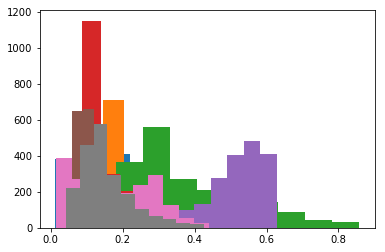

In [18]:
scores = []

for i, label in enumerate(moviedata.genre_labels):
    clf = LogisticRegression()
    clf.fit(X_train, y_train[:, i])
    y_pred_probs = clf.predict_proba(X_test)[:, 1]
    plt.hist(y_pred_probs)
    y_pred = np.array(y_pred_probs > np.mean(y_pred_probs), dtype=int)
    score = f1_score(y_test[:, i], y_pred)
    scores.append(score)
    print("Genre: {}, Score: {:.2f}".format(label, score))
    
print('Mean f1 score: {:.3f}'.format(np.mean(scores)))

# Random Forrest

In [19]:
clf = RandomForestClassifier(n_estimators=25, max_features='auto', max_depth=None)
clf.fit(X_train, y_train)
y_guess_probs = clf.predict_proba(X_test)
y_guess = clf.predict(X_test)

In [36]:
scores = f1_score(y_test, y_guess, average=None)
print(scores)

scores = []
for i, label in enumerate(moviedata.genre_labels):
    score = f1_score(y_test[:, i], y_guess[:, i])
    print("Genre: {}, Score: {:.2f}".format(label, score))

[ 0.41810919  0.24646465  0.4709389   0.16851441  0.56578947  0.15602837
  0.208       0.19477435]
Genre: Action, Score: 0.42
Genre: Adventure, Score: 0.25
Genre: Comedy, Score: 0.47
Genre: Crime, Score: 0.17
Genre: Drama, Score: 0.57
Genre: Horror, Score: 0.16
Genre: Romance, Score: 0.21
Genre: Thriller, Score: 0.19


In [21]:
print(np.mean(scores))

0.303577416634


In [27]:
# guess randomly
np.mean(f1_score(y_test, np.random.randint(0, 2, y_test.shape), average=None))

0.30729155785771584

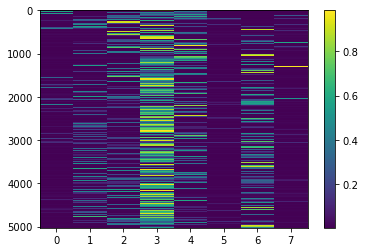

In [23]:
plt.imshow(Z, aspect='auto')
plt.colorbar()

In [61]:
lda.components_[0][lda.components_[0].argsort()[:-20 - 1:-1]]

array([ 93.03473834,  48.91509392,  41.38983992,  32.29735759,
        30.95530691,  28.3655226 ,  22.83024461,  21.76065345,
        20.54721074,  18.78593885,  18.34887839,  17.87008962,
        16.56989074,  15.55772322,  15.51828945,  15.31773653,
        15.10232459,  14.9612657 ,  14.42945393,  14.38995777])

In [63]:
np.arange(20)[:10:-1]

array([19, 18, 17, 16, 15, 14, 13, 12, 11])